In [618]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from d2l import torch as d2l

In [619]:
number_of_epochs = 3

In [620]:
class LinearNN(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        input_size = data.train.shape[1]-1
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard('x')
        self.linear1 = nn.LazyLinear(200)
        self.leakyRelu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        self.linear2 = nn.Linear(200,100)
        self.leakyRelu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(100, 1)
    def forward(self,X):
        modelOutput = self.linear1(X)
        modelOutput = self.leakyRelu1(modelOutput)
        modelOutput = self.dropout1(modelOutput)
        modelOutput = self.linear2(modelOutput)
        modelOutput = self.leakyRelu2(modelOutput)
        modelOutput = self.linear3(modelOutput)
        return modelOutput
    def loss(self, y_hat, y):
        loss = nn.MSELoss()
        return loss(y_hat, y)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr, weight_decay=0.01)
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)

In [621]:
class LinearNN_NoDropout_NoWeightDecay(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        input_size = data.train.shape[1]-1
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard('x')
        self.linear1 = nn.LazyLinear(200)
        self.leakyRelu1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(200,100)
        self.leakyRelu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(100, 1)
    def forward(self,X):
        modelOutput = self.linear1(X)
        modelOutput = self.leakyRelu1(modelOutput)
        modelOutput = self.linear2(modelOutput)
        modelOutput = self.leakyRelu2(modelOutput)
        modelOutput = self.linear3(modelOutput)
        return modelOutput
    def loss(self, y_hat, y):
        loss = nn.MSELoss()
        return loss(y_hat, y)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)

In [622]:
class Trainer(d2l.HyperParameters):  #@save
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

In [623]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
            sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
            d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
            sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [624]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [625]:
print(data.raw_train.iloc[:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [626]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
        self.raw_val.drop(columns=['Id'])))
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    features[numeric_features] = features[numeric_features].fillna(0)
    features = pd.get_dummies(features, dummy_na=True)
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [627]:
data.preprocess()
data.train.shape

(1460, 332)

In [628]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    tensors = (get_tensor(data.drop(columns=[label])),
             torch.log(get_tensor(data[label])).reshape((-1,1)))
    return self.get_tensorloader(tensors, train)

In [629]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                               data.train.loc[idx]))
        return rets

In [630]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearNN(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation mse = 0.0710613951086998


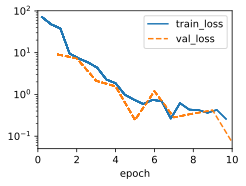

In [631]:
trainer = d2l.Trainer(max_epochs=10)
models=k_fold(trainer, data, k=5, lr=0.01)

In [632]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation mse = 0.18739998042583467


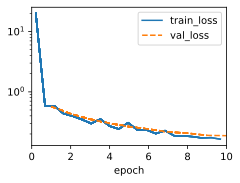

In [633]:
trainer = d2l.Trainer(max_epochs=10)
models=k_fold(trainer, data, k=5, lr=0.01)

In [634]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearNN_NoDropout_NoWeightDecay(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation mse = 0.05746385604143143


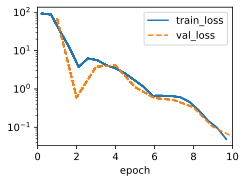

In [635]:
trainer = d2l.Trainer(max_epochs=10)
models=k_fold(trainer, data, k=5, lr=0.01)

In [636]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
            for model in models]
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                          'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)